# The Error Correction RNN

## Index

1. Task
2. Data
2. An Off-the-shelf Seq2Seq RNN
3. Training and Evaluation

## Section 1: Task

The network we're about to train is not going to directly serve any practical application. 
It's meant to serve as a proof of concept. 

We want to show in principle that a neural network can be used to **reconstruct a document from faulty copies** of that document. 

The concept is meant to be used in my course project (see https://www.dropbox.com/s/941wnu50197gshs/DLAM_Expose.pdf?dl=0%29).

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

### 1.1 Example

A task for our network will look like this:

```
Original = crying

Copy1 = crn
Copy2 = orreng
Copy3 = crywing

```

The network receives the copies as an input and reconstructs the original word.

```
Network output = crying
```

## Section 2: Data

In [29]:
# load tokenized sentences from the gutenberg corpus
from nltk.corpus import gutenberg

sents = []
for fileid in gutenberg.fileids():
    for sent in gutenberg.sents(fileid):
        sents.append(sent)

print('Number of words in dataset:\t', sum(len(sent) for sent in sents))
print('\nExample dataset entry:\n', sents[195])

Number of words in dataset:	 2621785

Example dataset entry:
 ['Now', ',', 'upon', 'his', 'father', "'", 's', 'marriage', ',', 'it', 'was', 'very', 'generally', 'proposed', ',', 'as', 'a', 'most', 'proper', 'attention', ',', 'that', 'the', 'visit', 'should', 'take', 'place', '.']


### 2.1 : Faulty Copy Machines

We will be using 3 different 'faulty copy machines' to generate the input for the network.

Each FCM will induce a certain kind of error with a certain probability.

In [2]:
import random
from random import randint
# use a seed for reproducibility
random.seed(1995)

#### FCM Hamburg
The fcm_hamburg will skip characters with a certain probability

In [3]:
HAMBURG_ERROR_PROB = 0.4

# create faulty copy machine hamburg
def fcm_hamburg(original_sents):
    copy_sents = []
    for original_sent in original_sents:
        copy_sent = []
        for original_token in original_sent:
            # skip characters with a certain probability
            copy_token = ''.join([char for char in original_token if random.random() > HAMBURG_ERROR_PROB])
            copy_sent.append(copy_token)
        copy_sents.append(copy_sent)
    return copy_sents

##### FCM Hamburg Example

In [4]:
print("Original Sentence:\n", sents[5])
print("\n")
print("Hamburg Sentence:\n",fcm_hamburg([sents[5]]))

Original Sentence:
 ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', ',', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection', '.']


Hamburg Sentence:
 [['Her', 'mothe', 'had', 'died', 'too', 'long', 'go', 'o', 'he', 'o', 'hav', 'm', 'th', 'a', 'distint', 'rembrnc', '', 'h', 'carsss', ';', 'and', 'hr', 'ace', 'ha', 'e', 'suppi', 'b', 'a', 'eele', 'oma', 's', 'gonss', '', 'wh', 'had', 'falen', 'll', 'sr', 'f', 'a', 'm', 'i', 'ffcon', '.']]


#### FCM Lisboa
fcm_lisboa replaces characters in it's copy with a certain probability.

The replacement-character for a character will always be the same.

In [41]:
LISBOA_ERROR_PROB = 0.3

charset = [char for sent in sents
                  for token in sent
                  for char in token]

# create the mapping that defines by which character another character will be replaced
lisboa_char_map = {}
for char in set(charset):
    lisboa_char_map[char] = random.choice(charset)
charset = None
def fcm_lisboa(original_sents, error_prob=0):
    copy_sents = []
    for original_sent in original_sents:
        copy_sent = []
        for original_token in original_sent:
            # replace certain chars with other certain chars with 
            copy_token = []
            for char in original_token:
                if random.random() < LISBOA_ERROR_PROB:
                    copy_char = lisboa_char_map[char]
                else:
                    copy_char = char
                copy_token.append(copy_char)
            copy_sent.append(''.join(copy_token))
        copy_sents.append(copy_sent)
    return copy_sents

##### FCM Lisboa Example

In [6]:
print("Original Sentence:\n", sents[5])
print("\n")
print("Lisboa Sentence:\n",fcm_lisboa([sents[5]]))

Original Sentence:
 ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', ',', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection', '.']


Lisboa Sentence:
 [['wer', 'mWnhgr', 'hxd', 'dhed', 'tWo', 'lWto', 'aoo', 'for', 'sgr', 'tW', 'savg', 'mWle', 'nhxt', 'an', 'inhhstincn', 'lgmembrantg', 'of', 'hel', 'targssgr', ';', 'and', 'sel', 'plxte', 'hxd', 'heen', 'supnthgh', 'by', 'xn', 'ercgllgnn', ';oyan', 'as', 'oodelnesr', 'r', 'whW', 'hxh', 'faltgt', 'thntlg', 'shWrn', 'of', 'a', 'yotsel', 'ht', 'acfectiot', '.']]


#### FCM Madrid

FCM Madrid inserts random characters with a certain probability

In [7]:
MADRID_ERROR_PROB = 0.4
# create faulty copy machine madrid
# FCM Madrid inserts random characters with a certain probability

def fcm_madrid(original_sents, error_prob=0):
    charset = [char for sent in original_sents
                  for token in sent
                  for char in token]
    
    copy_sents = []
    for original_sent in original_sents:
        copy_sent = []
        for original_token in original_sent:
            # insert random chars with a certain probability
            copy_token = []
            for char in original_token:
                if random.random() < MADRID_ERROR_PROB:
                    copy_token.append(charset[randint(0, len(charset)-1)])
                copy_token.append(char)
            copy_sent.append(''.join(copy_token))
        copy_sents.append(copy_sent)
    return copy_sents

##### FCM Lisboa Example

In [8]:
print("Original Sentence:\n", sents[5])
print("\n")
print("Madrid Sentence:\n",fcm_madrid([sents[5]]))

Original Sentence:
 ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', ',', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection', '.']


Madrid Sentence:
 [['tHeer', 'rm.otcherr', 'hiad', 'diaehd', 'too', 'loong', 'ageo', 'rfor', 'iher', 'eto', 'hatvoe', 'morae', 'othan', 'an', 'inmdaisltoinct', 'rlemeeombfranndce', 'eof', 'her', 'catreassess', ';', ';anod', 'bhoetr', 'apfltace', 'had', 'btenean', 'esnuopptlilerd', 'by', 'an', 'rebxcellent', 'ewobman', 'as', 'gaovcerneosas', ',', 'hwlho', 'lhrad', 'falsloein', 'litttrle', 'rshrort', 'olf', 'ra', 'mother', 'idn', 'aaffectihoen', 'l.']]


#### Feature Representation
We are using a sequence to sequence network, that was originally created for the task of language-translation. To make the output sequences of our three copy machines consumable for the network we have to represent as a single sequence. 

We do that by concatinating them character by character as shown in the following example:


In [64]:
def feature_word(original_word):
    result = []
    hamburg_word = fcm_hamburg([original_word])[0]
    lisboa_word = fcm_lisboa([original_word])[0]
    madrid_word = fcm_madrid([original_word])[0]
    feature_word = []
    word_lens = [len(word) for word in [hamburg_word, lisboa_word, madrid_word, original_word]]
    for char_idx in range(max(word_lens)):
        feature_char = ''
        try:
            feature_char += hamburg_word[char_idx]
        except(IndexError):
            feature_char += '#'
        try:
            feature_char += lisboa_word[char_idx]
        except(IndexError):
            feature_char += '#'
        try:
            feature_char += madrid_word[char_idx]
        except(IndexError):
            feature_char += '#'
        result.append(feature_char)
    return result
    
feature_word('Was')

['WrW', 'aasa', 'sss']

In [52]:
# CREATE FAULTY COPYS OF 'm
def print_examples_for_representation(word):
    print("Hamburg: ", ''.join(fcm_hamburg([word])[0]))
    print("Lisboa: ", ''.join(fcm_lisboa([word])[0]))
    print("Madrid: ", ''.join(fcm_madrid([word])[0]))
    print()
    print(build_feature_label_pairs([['Maximilian']]))
    
print_examples_for_representation('Maximilian')

Hamburg:  ximln
Lisboa:  MaxYeilYan
Madrid:  Malximiimlmialn

[[['a', 'e', 'M', 'x', 'a', 'a', 'i', 't', 'x', 'i', 'i', 'i', 'i', 'e', 'm', 'a', 'i', 'i', 'n', 'l', 'l', '#', 'Y', 'i', '#', 'm', 'i', '#', 'n', 'l', '#', '#', 'a', '#', '#', 'n'], ['M', 'a', 'x', 'i', 'm', 'i', 'l', 'i', 'a', 'n']]]


In [51]:
def build_feature_label_pairs(original_sents):
    result = []
    for original_sent in original_sents:
        hamburg_sent = fcm_hamburg([original_sent])[0]
        lisboa_sent = fcm_lisboa([original_sent])[0]
        madrid_sent = fcm_madrid([original_sent])[0]
        
        feature_sent = []
        
        for idx, original_word in enumerate(original_sent):
            
            hamburg_word = hamburg_sent[idx]
            lisboa_word = lisboa_sent[idx]
            madrid_word = madrid_sent[idx]
            feature_word = []
            word_lens = [len(word) for word in [hamburg_word, lisboa_word, madrid_word, original_word]]
            for char_idx in range(max(word_lens)):
                feature_char = ''
                try:
                    feature_char += hamburg_word[char_idx]
                except(IndexError):
                    feature_char += '#'
                try:
                    feature_char += lisboa_word[char_idx]
                except(IndexError):
                    feature_char += '#'
                try:
                    feature_char += madrid_word[char_idx]
                except(IndexError):
                    feature_char += '#'
                # feature_word.append(feature_char)
                feature_word += list(feature_char)
            result.append([feature_word, list(original_word)])
            feature_sent += feature_word
            if idx < len(original_sent)-1:
                feature_sent.append(' ')
        #result.append([feature_sent, list(' '.join(original_sent))])
    return result

In [32]:
data_pair = build_feature_label_pairs([sents[4]])[0]
feature = data_pair[0]
label = data_pair[1]
print("Feature:\n", feature)
print("\n")
print("Label:\n", label)

Feature:
 ['h', 'b', 'S', '#', 'h', 'h', '#', 'e', 'e']


Label:
 ['S', 'h', 'e']


In [11]:
def build_shuffle_pairs(sents):
    shuffled_sents = []
    for sent in sents:
        shuffled_sent = []
        for word in sent:
            shuffled_word = list(word)
            random.shuffle(shuffled_word)
            shuffled_sent.append(''.join(shuffled_word))
        shuffled_sents.append(shuffled_sent)
    return build_feature_label_pairs(shuffled_sents)

In [15]:
def prepareData(factor):
    input_lang = Lang('flawed_chars')
    output_lang = Lang('correct_chars')
    pairs = []
    for i in range(factor):
        pairs += build_feature_label_pairs(sents)
    pairs += build_shuffle_pairs(sents)
    print("Read %s word pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addWord(pair[0])
        output_lang.addWord(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(1)
sents = None

Read 5243570 word pairs
Counting words...
Counted words:
flawed_chars 97
correct_chars 96


In [13]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        for char in word:
            self.addChar(char)
            
    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

#lang = Lang("idk")
#for sent in sents:
#    lang.addSentence(sent)
    
#print(lang.char2index)

Read 10487140 word pairs
Counting words...
Counted words:
flawed_chars 97
correct_chars 96


In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
feature_lens = []
for pair in pairs:
    feature_lens.append(len(pair[0]))
MAX_LENGTH = max(feature_lens)
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [20]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.008):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # showPlot(plot_losses)
    return plot_losses

In [23]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        
        hamburg = ''
        lisboa = ''
        madrid = ''
        i = 0
        while i < len(pair[0]):
            hamburg += pair[0][i]
            lisboa += pair[0][i+1]
            madrid += pair[0][i+2]
            i += 3
        print('Hamburg >', hamburg)
        print('Lisboa >', lisboa)
        print('Madrid >', madrid)            
        print('=', ''.join(pair[1]))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words[:-1])
        print('<', output_sentence)
        print('')

2m 28s (- 593m 15s) (5000 0%) 1.7539
4m 41s (- 558m 58s) (10000 0%) 1.0453
6m 55s (- 547m 1s) (15000 1%) 0.8002
9m 5s (- 536m 0s) (20000 1%) 0.6382
11m 18s (- 531m 46s) (25000 2%) 0.5754
13m 29s (- 526m 29s) (30000 2%) 0.4826
15m 37s (- 520m 11s) (35000 2%) 0.4587
17m 46s (- 515m 15s) (40000 3%) 0.4010
19m 56s (- 511m 39s) (45000 3%) 0.4079
22m 9s (- 509m 47s) (50000 4%) 0.3673
24m 16s (- 505m 21s) (55000 4%) 0.3557
26m 23s (- 501m 35s) (60000 5%) 0.3452
28m 32s (- 498m 20s) (65000 5%) 0.3265
30m 40s (- 495m 11s) (70000 5%) 0.3347
32m 47s (- 491m 55s) (75000 6%) 0.2905
34m 55s (- 488m 59s) (80000 6%) 0.3072
37m 4s (- 486m 21s) (85000 7%) 0.2940
39m 10s (- 483m 8s) (90000 7%) 0.2875
41m 17s (- 480m 20s) (95000 7%) 0.2893
43m 25s (- 477m 43s) (100000 8%) 0.2877
45m 33s (- 475m 7s) (105000 8%) 0.2858
47m 39s (- 472m 15s) (110000 9%) 0.2695
49m 48s (- 469m 52s) (115000 9%) 0.2779
51m 55s (- 467m 15s) (120000 10%) 0.2843
54m 2s (- 464m 43s) (125000 10%) 0.2689
56m 11s (- 462m 31s) (130000 1

493m 38s (- 98m 43s) (1000000 83%) 0.1122
496m 20s (- 96m 18s) (1005000 83%) 0.1047
499m 5s (- 93m 53s) (1010000 84%) 0.1070
501m 49s (- 91m 27s) (1015000 84%) 0.1140
504m 34s (- 89m 2s) (1020000 85%) 0.1098
507m 18s (- 86m 36s) (1025000 85%) 0.1010
510m 1s (- 84m 10s) (1030000 85%) 0.1172
512m 44s (- 81m 44s) (1035000 86%) 0.1025
515m 28s (- 79m 18s) (1040000 86%) 0.1137
518m 9s (- 76m 51s) (1045000 87%) 0.1020
520m 50s (- 74m 24s) (1050000 87%) 0.1126
523m 33s (- 71m 57s) (1055000 87%) 0.1115
526m 14s (- 69m 30s) (1060000 88%) 0.1095
528m 58s (- 67m 3s) (1065000 88%) 0.1135
531m 40s (- 64m 35s) (1070000 89%) 0.1088
534m 21s (- 62m 8s) (1075000 89%) 0.1128
537m 5s (- 59m 40s) (1080000 90%) 0.1091
539m 50s (- 57m 13s) (1085000 90%) 0.1284
542m 34s (- 54m 45s) (1090000 90%) 0.1149
545m 16s (- 52m 17s) (1095000 91%) 0.1509
547m 58s (- 49m 48s) (1100000 91%) 0.2299
550m 41s (- 47m 20s) (1105000 92%) 0.1997
553m 23s (- 44m 52s) (1110000 92%) 0.1688
556m 8s (- 42m 23s) (1115000 92%) 0.2024


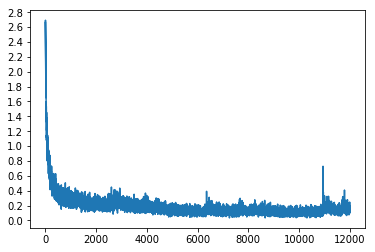

In [26]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

points = trainIters(encoder1, attn_decoder1, 2*600000, print_every=5000)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(points)
plt.show()

2m 33s (- 304m 22s) (5000 0%) 1.7512
4m 50s (- 286m 7s) (10000 1%) 0.9791
7m 8s (- 278m 24s) (15000 2%) 0.7409
9m 25s (- 273m 19s) (20000 3%) 0.5920
12m 7s (- 278m 41s) (25000 4%) 0.5231
14m 46s (- 280m 49s) (30000 5%) 0.4694
17m 28s (- 281m 58s) (35000 5%) 0.4435
20m 9s (- 282m 12s) (40000 6%) 0.3998
22m 49s (- 281m 28s) (45000 7%) 0.3822
25m 29s (- 280m 24s) (50000 8%) 0.3505
28m 12s (- 279m 33s) (55000 9%) 0.3499
30m 54s (- 278m 12s) (60000 10%) 0.3260
33m 37s (- 276m 43s) (65000 10%) 0.3250
36m 19s (- 275m 2s) (70000 11%) 0.3032
39m 1s (- 273m 8s) (75000 12%) 0.3058
41m 42s (- 271m 6s) (80000 13%) 0.3019
44m 24s (- 269m 4s) (85000 14%) 0.2870
47m 6s (- 266m 57s) (90000 15%) 0.2695
49m 47s (- 264m 42s) (95000 15%) 0.2617
52m 27s (- 262m 18s) (100000 16%) 0.2620
55m 9s (- 260m 0s) (105000 17%) 0.2694
57m 49s (- 257m 35s) (110000 18%) 0.2426
60m 32s (- 255m 21s) (115000 19%) 0.2628
63m 14s (- 252m 56s) (120000 20%) 0.2410
65m 54s (- 250m 26s) (125000 20%) 0.2431
68m 35s (- 247m 58s) (

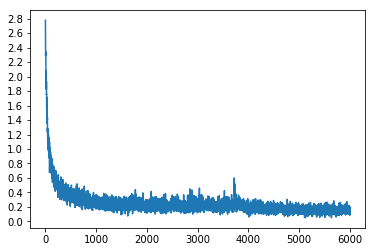

In [25]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

points = trainIters(encoder1, attn_decoder1, 600000, print_every=5000)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(points)
plt.show()

In [33]:
evaluateRandomly(encoder1, attn_decoder1)

Hamburg > ###
Lisboa > of#
Madrid > otf
= of
< of

Hamburg > H##
Lisboa > He#
Madrid > Hte
= He
< He

Hamburg > crn####
Lisboa > orreng#
Madrid > crywing
= crying
< crying

Hamburg > (
Lisboa > .
Madrid > (
= (
< (

Hamburg > rhtee
Lisboa > nalet
Madrid > rhtee
= rhtee
< rhtee

Hamburg > insea####
Lisboa > ewdltid##
Madrid > ifntstead
= instead
< instaad

Hamburg > tl######
Lisboa > ltlr####
Madrid > ttfeolal
= tell
< tell

Hamburg > .
Lisboa > .
Madrid > .
= .
< .

Hamburg > ###
Lisboa > ane
Madrid > are
= are
< are

Hamburg > f###
Lisboa > iond
Madrid > form
= form
< form



2m 24s (- 141m 37s) (5000 1%) 1.6314
4m 48s (- 139m 35s) (10000 3%) 0.8437
7m 12s (- 137m 5s) (15000 5%) 0.5883
9m 37s (- 134m 51s) (20000 6%) 0.4738
12m 1s (- 132m 21s) (25000 8%) 0.4184
14m 24s (- 129m 40s) (30000 10%) 0.3649
16m 47s (- 127m 4s) (35000 11%) 0.3325
19m 11s (- 124m 45s) (40000 13%) 0.3017
21m 33s (- 122m 11s) (45000 15%) 0.2774
23m 57s (- 119m 48s) (50000 16%) 0.2638
26m 43s (- 119m 3s) (55000 18%) 0.2601
29m 31s (- 118m 4s) (60000 20%) 0.2563
32m 16s (- 116m 39s) (65000 21%) 0.2286
35m 0s (- 115m 0s) (70000 23%) 0.2229
37m 49s (- 113m 29s) (75000 25%) 0.2240
40m 36s (- 111m 40s) (80000 26%) 0.2088
43m 18s (- 109m 33s) (85000 28%) 0.2070
46m 10s (- 107m 43s) (90000 30%) 0.1985
49m 4s (- 105m 53s) (95000 31%) 0.2061
51m 54s (- 103m 49s) (100000 33%) 0.1873
54m 47s (- 101m 46s) (105000 35%) 0.1957
57m 39s (- 99m 35s) (110000 36%) 0.1782
60m 32s (- 97m 24s) (115000 38%) 0.1725
63m 22s (- 95m 3s) (120000 40%) 0.1619
66m 14s (- 92m 43s) (125000 41%) 0.1677
69m 6s (- 90m 22s

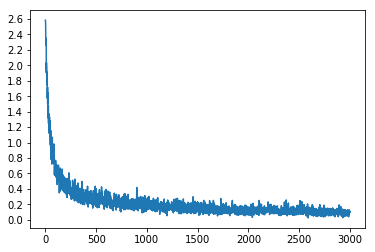

In [37]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

points = trainIters(encoder1, attn_decoder1, 300000, print_every=5000)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(points)
plt.show()

In [39]:
evaluateRandomly(encoder1, attn_decoder1)

Hamburg > h####
Lisboa > lhus#
Madrid > thnus
= thus
< thus

Hamburg > ears###
Lisboa > yelre##
Madrid > Dyearrs
= years
< years

Hamburg > ,
Lisboa > ,
Madrid > ,
= ,
< ,

Hamburg > dely#######
Lisboa > eueefnly###
Madrid > s.udddenley
= suddenly
< suddenly

Hamburg > put#
Lisboa > phl#
Madrid > punt
= put
< put

Hamburg > cannibal##
Lisboa > cannlbal##
Madrid > ecannkibal
= cannibal
< cannibal

Hamburg > ###
Lisboa > ii#
Madrid > i22
= 22
< 22

Hamburg > spue##
Lisboa > ephe##
Madrid > tspuce
= spue
< spue

Hamburg > whle####
Lisboa > wchlf###
Madrid > whfollwe
= whole
< whele

Hamburg > o########
Lisboa > hhreee###
Madrid > heorroses
= horses
< horses



8m 10s (- 481m 51s) (5000 1%) 1.6572
17m 8s (- 497m 7s) (10000 3%) 0.8094
26m 20s (- 500m 33s) (15000 5%) 0.5326
34m 13s (- 479m 6s) (20000 6%) 0.4231
41m 21s (- 454m 51s) (25000 8%) 0.3600
50m 3s (- 450m 29s) (30000 10%) 0.3167
56m 1s (- 424m 13s) (35000 11%) 0.2802
61m 55s (- 402m 28s) (40000 13%) 0.2860
67m 42s (- 383m 41s) (45000 15%) 0.2606
73m 26s (- 367m 13s) (50000 16%) 0.2652
79m 9s (- 352m 36s) (55000 18%) 0.2340
84m 55s (- 339m 41s) (60000 20%) 0.2225
90m 37s (- 327m 38s) (65000 21%) 0.2151
96m 16s (- 316m 20s) (70000 23%) 0.2091
101m 59s (- 305m 57s) (75000 25%) 0.2526
107m 51s (- 296m 36s) (80000 26%) 0.2363
114m 20s (- 289m 13s) (85000 28%) 0.2354
120m 56s (- 282m 11s) (90000 30%) 0.2140
127m 32s (- 275m 13s) (95000 31%) 0.2138
134m 0s (- 268m 1s) (100000 33%) 0.2120
140m 12s (- 260m 23s) (105000 35%) 0.1917
145m 56s (- 252m 5s) (110000 36%) 0.1821
151m 47s (- 244m 11s) (115000 38%) 0.1887
157m 36s (- 236m 24s) (120000 40%) 0.1838
163m 21s (- 228m 41s) (125000 41%) 0.1767

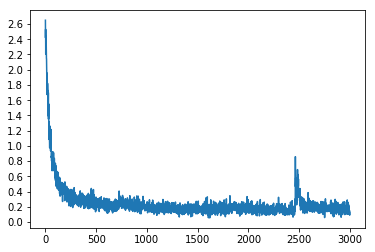

In [23]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

points = trainIters(encoder1, attn_decoder1, 300000, print_every=5000)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(points)
plt.show()

In [26]:
evaluateRandomly(encoder1, attn_decoder1)

Hamburg > ,
Lisboa > o
Madrid > ,
= ,
< ,

Hamburg > ###
Lisboa > ane
Madrid > and
= and
< and

Hamburg > h#
Lisboa > se
Madrid > he
= he
< he

Hamburg > yu#
Lisboa > dou
Madrid > nau
= you
< you

Hamburg > cre######
Lisboa > cphporhhe
Madrid > oetefrate
= celebrate
< cetporate

Hamburg > ep##
Lisboa > epep
Madrid > ,ean
= keep
< sepe

Hamburg > si###
Lisboa > skihh
Madrid > tkceg
= skill
< skilt

Hamburg > ##
Lisboa > hp
Madrid > oe
= he
< he

Hamburg > fai###
Lisboa > oairld
Madrid > naiceh
= fairly
< fairly

Hamburg > sn####
Lisboa > ehcced
Madrid > tinrue
= sinned
< sinced

